In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

In [2]:
spark = SparkSession.builder.appName('BikeShareLinearRegression') \
.config('spark.warehouse.dir','/apps/hive/warehouse') \
.config('spark.driver.memory', '4G') \
.config('spark.sql.shuffle.partitions', 4) \
.enableHiveSupport().getOrCreate()

In [3]:
# Having set the driver and driver options we should have spark representing spark session 
# available straight away
spark.version

'3.1.3'

In [4]:
sc = spark.sparkContext

In [5]:
sc.setLogLevel('ERROR')

In [19]:
from pyspark.ml.feature  import VectorAssembler, VectorIndexer, OneHotEncoder
from pyspark.sql.types import DataType
from pyspark.sql import DataFrame
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.regression import LinearRegression, LinearRegressionModel, GeneralizedLinearRegression
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PolynomialExpansion

In [20]:
#  load the bike sharing dataset
#  the independent variables are dteday, season , year, month, hour, holiday, weekday, 
#  workingday, normalized temperature, apparent normalized temperature, normalized humidity, windspeed
#  the value we are intersted in predicting is cnt - the number of bike rentals for that hour
fileloc = "C:/Users/Administrator/Downloads/hour.csv"
df = spark.read.format("csv").option("header", "true").load( fileloc)

In [21]:
df.registerTempTable("BikeSharing")
print(df.count())
spark.sql("SELECT * FROM BikeSharing").show()

C:\ProgramData\Anaconda3\lib\site-packages\pyspark\sql\dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


17379
+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant|    dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+----------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|2011-01-01|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|        0|     3|        13| 16|
|      2|2011-01-01|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     8|        32| 40|
|      3|2011-01-01|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|        0|     5|        27| 32|
|      4|2011-01-01|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|        0|     3|        10| 13|
|      5|2011-01-01|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|   

In [10]:
# drop record id, date, casual and registered columns
df1 = df.drop("instant").drop("dteday").drop("casual").drop("registered")

In [11]:
#  convert to double: season,yr,mnth,hr,holiday,weekday,workingday,weathersit,
#  temp,atemp,hum,windspeed,casual,registered,cnt
df2 = df1.withColumn("season", df1["season"].cast("double")) \
.withColumn("yr", df1["yr"].cast("double")) \
.withColumn("mnth", df1["mnth"].cast("double")) \
.withColumn("hr", df1["hr"].cast("double")) \
.withColumn("holiday", df1["holiday"].cast("double")) \
.withColumn("weekday", df1["weekday"].cast("double")) \
.withColumn("workingday", df1["workingday"].cast("double")) \
.withColumn("weathersit", df1["weathersit"].cast("double")) \
.withColumn("temp", df1["temp"].cast("double")) \
.withColumn("atemp", df1["atemp"].cast("double")) \
.withColumn("hum", df1["hum"].cast("double")) \
.withColumn("windspeed", df1["windspeed"].cast("double")) \
.withColumn("label", df1["cnt"].cast("double")) \
.drop("cnt")

In [12]:
windHist = df2.select("windspeed").toPandas()

In [13]:
windHist[:10]

,windspeed
0,0.0000
1,0.0000
2,0.0000
3,0.0000
4,0.0000
5,0.0896
6,0.0000
7,0.0000
8,0.0000
9,0.0000


In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(array([2.180e+03, 6.475e+03, 4.465e+03, 2.458e+03, 1.137e+03, 4.340e+02,
        1.670e+02, 4.800e+01, 9.000e+00, 6.000e+00]),
 array([0.     , 0.08507, 0.17014, 0.25521, 0.34028, 0.42535, 0.51042,
        0.59549, 0.68056, 0.76563, 0.8507 ]),
 <BarContainer object of 10 artists>)

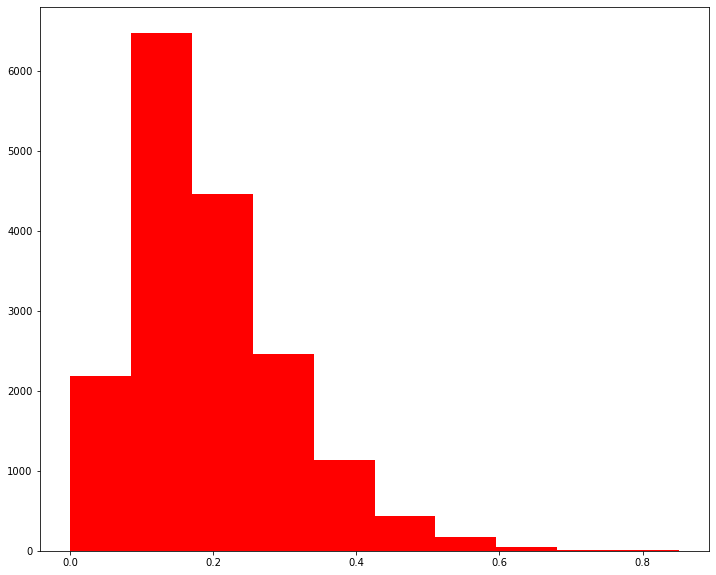

In [16]:
import matplotlib as mpl
from matplotlib import pyplot as plt
fig = plt.figure()
fig.set_size_inches(12, 10)
plt.hist(windHist.iloc[:, 0], bins=10, color='r')

In [22]:
encoder = OneHotEncoder().setInputCols(
    ["season", "yr", "mnth", "hr", "holiday","weekday", "workingday", "weathersit"]).setOutputCols(
    ["seasonVec", "yrVec", "mnthVec", "hrVec", "holidayVec","weekdayVec", "workingdayVec", "weathersitVec"])

In [23]:
ohemodel = encoder.fit(df2)
oheEncoded = ohemodel.transform(df2)
df3 = oheEncoded.drop("season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit")
featureCols = df3.drop("label").columns
print(featureCols)

['temp', 'atemp', 'hum', 'windspeed', 'seasonVec', 'yrVec', 'mnthVec', 'hrVec', 'holidayVec', 'weekdayVec', 'workingdayVec', 'weathersitVec']


In [24]:
vectorAssembler = VectorAssembler().setInputCols(featureCols).setOutputCol("features")

In [25]:
lr = LinearRegression() \
.setFeaturesCol("features") \
.setLabelCol("label") \
.setRegParam(0.1) \
.setElasticNetParam(1.0) \
.setMaxIter(20)

In [26]:
pipeline = Pipeline().setStages([vectorAssembler, lr])

In [27]:
training, test = df3.randomSplit([0.8, 0.2], seed = 12345)

In [28]:
model = pipeline.fit(training)

In [29]:
fullPredictions = model.transform(test).cache()
predictions = fullPredictions.select("prediction").rdd.map(lambda x: x[0])
labels = fullPredictions.select("label").rdd.map(lambda x: x[0])
regMetrics = RegressionMetrics(predictions.zip(labels))
RMSE = regMetrics.rootMeanSquaredError
print('Root Mean Squared Error: ', RMSE)
r2_cod = regMetrics.r2
print('Cofficient of determiniation: ', r2_cod)

C:\ProgramData\Anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Root Mean Squared Error:  103.27942960573503
Cofficient of determiniation:  0.676383909613252


In [30]:
lr_grid = LinearRegression()
paramGrid = ParamGridBuilder().addGrid(lr_grid.regParam, [0.1, 0.01, 0.00]) \
.addGrid(lr_grid.fitIntercept, [True, False]) \
.addGrid(lr_grid.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])\
.addGrid(lr_grid.tol, [0.01, 0.001, 0.0001]) \
.build()
lr_grid.setMaxIter(1000)
pipelineGrid = Pipeline().setStages([vectorAssembler, lr_grid])

In [31]:
trainValidationSplit = TrainValidationSplit() \
.setEstimator(pipelineGrid) \
.setEvaluator(RegressionEvaluator()) \
.setEstimatorParamMaps(paramGrid) \
.setTrainRatio(0.8)

In [32]:
linModelPipeline = trainValidationSplit.fit(training)
gridPredictions = linModelPipeline.transform(test).select("label", "prediction")
r2lmp = RegressionMetrics(gridPredictions.rdd.map(lambda x: (x[1], x[0])))
print(r2lmp.rootMeanSquaredError)
print(r2lmp.r2)

103.69819016733048
0.6737542980110645


In [33]:
bestPipelineModel = linModelPipeline.bestModel
blinModel = bestPipelineModel.stages[1]
blinModel.extractParamMap()
print(blinModel.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.75)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True, current: False)
labelCol: label column name. (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter: max number of iteration

In [34]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, numFolds=3, 
                          evaluator=RegressionEvaluator())

In [35]:
cvModel = crossval.fit(training)

In [36]:
cv_predictions = cvModel.transform(test)

In [37]:
cvPredictions = cvModel.transform(test).select("label", "prediction")
r2cvm = RegressionMetrics(cvPredictions.rdd.map(lambda x: (x[1], x[0])))
print(r2cvm.rootMeanSquaredError)
print(r2cvm.r2)

103.27942960573503
0.676383909613252


In [38]:
cvModel.extractParamMap()

{Param(parent='CrossValidatorModel_bbc808128bd0', name='seed', doc='random seed.'): -3180810853199705224,
 Param(parent='CrossValidatorModel_bbc808128bd0', name='numFolds', doc='number of folds for cross validation'): 3,
 Param(parent='CrossValidatorModel_bbc808128bd0', name='foldCol', doc="Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with range [0, numFolds) and Spark will throw exception on out-of-range fold numbers."): '',
 Param(parent='CrossValidatorModel_bbc808128bd0', name='estimator', doc='estimator to be cross-validated'): Pipeline_084e517e4efb,
 Param(parent='CrossValidatorModel_bbc808128bd0', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LinearRegression_b935a1ce2e1e', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LinearRegression_b935a1ce2e1e', name='fitIntercept', doc='whether t

In [39]:
print(cvModel.explainParams())

estimator: estimator to be cross-validated (current: Pipeline_084e517e4efb)
estimatorParamMaps: estimator param maps (current: [{Param(parent='LinearRegression_b935a1ce2e1e', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LinearRegression_b935a1ce2e1e', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_b935a1ce2e1e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_b935a1ce2e1e', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0).'): 0.01}, {Param(parent='LinearRegression_b935a1ce2e1e', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LinearRegression_b935a1ce2e1e', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_b935a1ce2e1e', name='elasticNetParam', doc='t